## IN3050/IN4050 Mandatory Assignment 2: Supervised Learning

Authored by \
Eirik Fredborg, eefredbo

### Initialization
We import some useful python modules that will be used to solve the tasks in this assignment. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn
from sklearn import datasets
from sklearn.datasets import make_blobs
import random
from collections import Counter
plt.rcParams['font.size'] = 16

## Introduction

This assignment consists of two parts: the first part will be exploring various data classifiers and comparing their performance. In the second part we will attempt to create a ulti-layer neural network classifier and evaluate this one up to the best of the classifiers evaluated in part one. 

Assignment text giving some background info and explaining the tasks that will be undertaken are marked in green in the jupyter notebook. All non-gree markdown text is part of the report attempting to answer the assgnment tasks. 



# Part 1: Comparing classifiers
The initial tasks are quite simple and well explained in the assignment description, so the code performing these tasks will not be extensively explained. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

    
    

  
## Datasets
    
    
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.
  
</div>

In [2]:
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [3]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10];

In [4]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.
</div>

In [5]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    

Plot the two training sets.
</div>

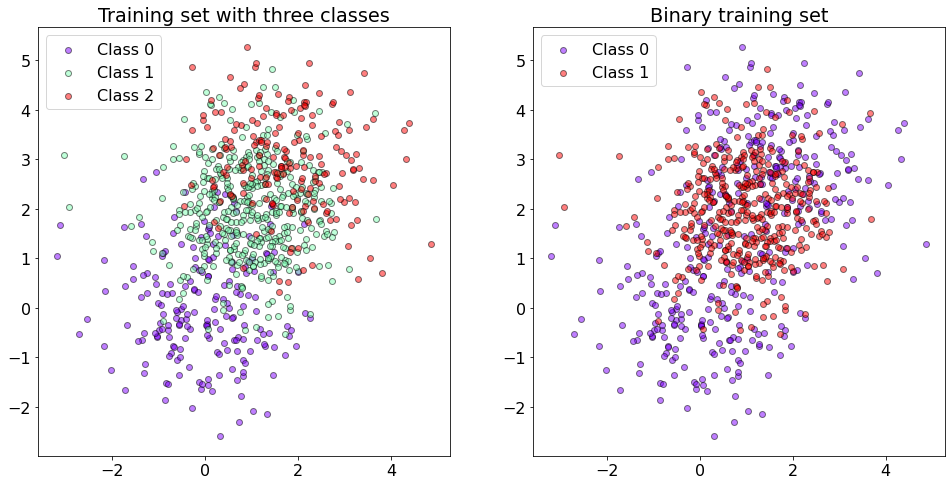

In [6]:
def show(X_set, t_set):
    t_unique = np.unique(t_set)
    colors = cm.rainbow(np.linspace(0.0, 1.0, t_unique.size))
    for this_t, color in zip(t_unique, colors):
        this_X = X_set[t_set == this_t]
        plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_t)
    plt.legend(loc="best")

plt.figure(figsize=(14,7))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
plt.subplot(121)
plt.title('Training set with three classes')
show(X_train, t_train)

plt.subplot(122)
plt.title('Binary training set')
show(X_train, t2_train)

plt.show()

In the figure above we see the two traning sets. The left plot contains a datasets consisting of three classes while the data in the right plot consists of two classes. We see that in both figures the data points form the different classes have significant overlap and is therefor not linearly separable. This makes it difficult for a classifier to be very accurate. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    


    
## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.
</div>

We define a function to add a bias feature in any given dataset. 

In [7]:
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1) 

We define a vectorized function for determining the accuracy of a classifier.

In [8]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)

We define a linear regression classifier that trains on a dataset until the improvement rate reach a satisfactory level. 

In [9]:
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, diff=1e-3):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        update= np.ones(m+1)*10
        #for e in range(epochs):
        epochs = 0
        while np.mean(np.abs(update))>diff:
            epochs +=1
            update = eta / k *  X_train.T @ (X_train @ weights - t_train)  
            weights -= update    
        #print(f'number of epochs = {epochs}')
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score>threshold

We evaluate the lienar classifier for different values of this improvement rate we stop training for, we will call this parameter traning resolution. We do this for learning rate $\eta=(0.10,0.01)$.

In [10]:
N = int(2e3)
lin_diff_arr = np.logspace(-6.5, -1.5, N)
lin_acc_arr1 = np.zeros(N)
lin_acc_arr2 = np.zeros(N)
lin_cl = NumpyLinRegClass()
for i in range(N):
    lin_cl.fit(X_train, t2_train,eta = 0.1, diff = lin_diff_arr[i])
    lin_acc_arr1[i] = lin_cl.accuracy(X_val, t2_val)
    lin_cl.fit(X_train, t2_train,eta = 0.01, diff = lin_diff_arr[i])
    lin_acc_arr2[i] = lin_cl.accuracy(X_val, t2_val)


We plot the computed accuracy as a function of trainer resolution for both learning rates.

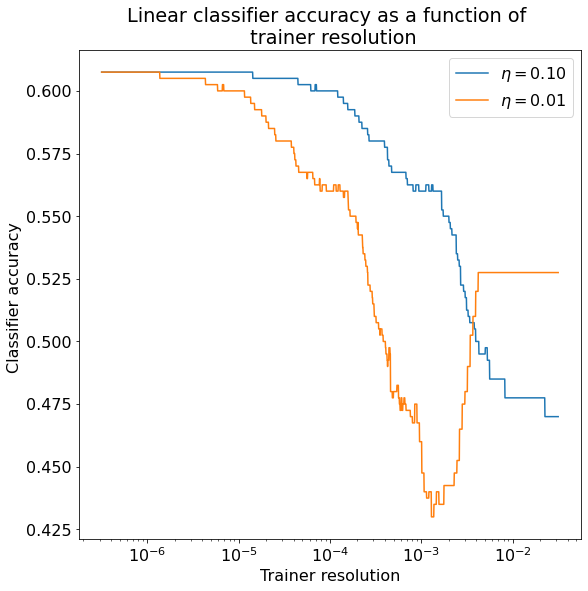

In [11]:

plt.figure(figsize = (9,9))
plt.title('Linear classifier accuracy as a function of \n trainer \
resolution')
plt.plot(lin_diff_arr, lin_acc_arr1, label=r'$\eta = 0.10$')
plt.plot(lin_diff_arr, lin_acc_arr2, label=r'$\eta = 0.01$')
plt.xscale('log')
plt.ylabel('Classifier accuracy ')
plt.xlabel('Trainer resolution')
plt.legend()
plt.show()

The figure above shows the performance of the linear classifier as a function of trainer resolution. We see that for higher learning rate the optimum is reaches at a lower traning resolution. 

We determine the optimal trainer resolition for the two cases.

In [12]:
#for eta = 0.1
lin_indx1 = np.where(lin_acc_arr1==np.max(lin_acc_arr1))[0]
opt_lin1 = np.max(lin_acc_arr1)
print(f'Optimal resolution for eta = 0.10 is for resolution \
< %.1E' % lin_diff_arr[lin_indx1[-1]])
print(f'The accuracy of the classifier is {opt_lin1} \
using these parameter values')

print('\n')

#for eta = 0.01
lin_indx2 = np.where(lin_acc_arr2==np.max(lin_acc_arr2))[0]
opt_lin2 = np.max(lin_acc_arr2)
print(f'Optimal training resolution for eta = 0.01 is for res \
< %.1E' % lin_diff_arr[lin_indx2[-1]])
print(f'The accuracy of the classifier is {opt_lin2} \
using these parameter values')

Optimal resolution for eta = 0.10 is for resolution < 1.4E-05
The accuracy of the classifier is 0.6075 using these parameter values


Optimal training resolution for eta = 0.01 is for res < 1.4E-06
The accuracy of the classifier is 0.6075 using these parameter values


We observe that both learning rates produce the same accuracy but for training resolution differing with a factor 10, similar to the difference in learning rate. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
    
    
  

### Logistic regression
    
Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.
</div>

We define a logistic classifier and perform the same analysis as with the linear classifier. 

In [13]:
def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyLogRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, diff = 1e-3):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        update= np.ones(m+1)*10
        #for e in range(epochs):
        while np.mean(np.abs(update))>diff:
            update = eta / k *  X_train.T @ (self.forward(X_train) - t_train)  
            weights -= update   
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')

In [14]:
N = int(3e3)
log_diff_arr = np.logspace(-4.5, -2, N)
log_acc_arr1 = np.zeros(N)
log_acc_arr2 = np.zeros(N)
log_cl = NumpyLogRegClass()
for i in range(N):
    log_cl.fit(X_train, t2_train,eta = 0.1, diff = log_diff_arr[i])
    log_acc_arr1[i] = log_cl.accuracy(X_val, t2_val)
    log_cl.fit(X_train, t2_train,eta = 0.01, diff = log_diff_arr[i])
    log_acc_arr2[i] = log_cl.accuracy(X_val, t2_val)


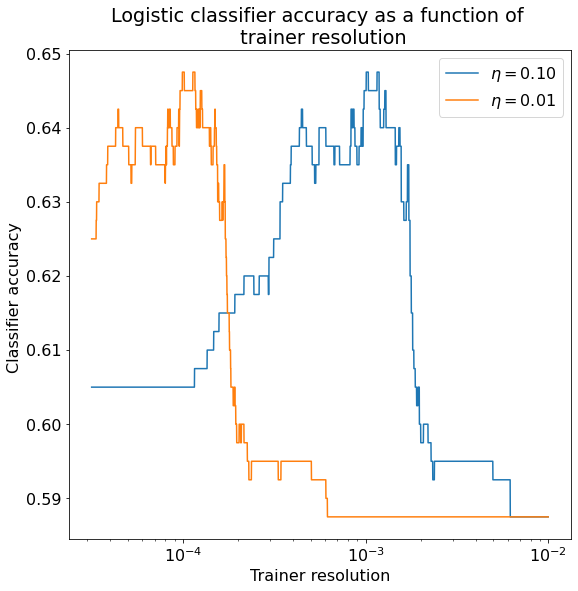

In [15]:
plt.figure(figsize = (9,9))
plt.title('Logistic classifier accuracy as a function of \n trainer \
resolution')
plt.plot(log_diff_arr, log_acc_arr1, label=r'$\eta = 0.10$')
plt.plot(log_diff_arr, log_acc_arr2, label=r'$\eta = 0.01$')
plt.xscale('log')
plt.ylabel('Classifier accuracy ')
plt.xlabel('Trainer resolution')
plt.legend()

plt.show()

Again we se simlar performance for both learning rates, and that slower learning rate needs lower training resolution corresponding to more training epochs to achieve the same accuracy. We see that the accuracy starts decreasing for a certain training resolution resulting in a optimum. 

In [16]:
#for eta = 0.1
log_indx1 = np.where(log_acc_arr1==np.max(log_acc_arr1))[0]

opt_log1 = np.max(log_acc_arr1)
print(f'Optimal resolution for eta = 0.10 is for resolution \
%.2E and %.2E' % (log_diff_arr[log_indx1[0]], log_diff_arr[log_indx1[-1]]))
print(f'The accuracy of the classifier is {opt_log1} \
using these parameter values')

print('\n')

#for eta = 0.01
log_indx2 = np.where(log_acc_arr2==np.max(log_acc_arr2))[0]
opt_log2 = np.max(log_acc_arr2)
print(f'Optimal resolution for eta = 0.01 is between \
%.2E and %.2E' % (log_diff_arr[log_indx2[0]], log_diff_arr[log_indx2[-1]]))
print(f'The accuracy of the classifier is {opt_log2} \
using these parameter values')

Optimal resolution for eta = 0.10 is for resolution 1.01E-03 and 1.19E-03
The accuracy of the classifier is 0.6475 using these parameter values


Optimal resolution for eta = 0.01 is between 9.93E-05 and 1.16E-04
The accuracy of the classifier is 0.6475 using these parameter values


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
    
    
    
    
    
    
    
    

### *k*-nearest neighbors (*k*NN)

We will now compare to the *k*-nearest neighbors classifier. You may use the implementation from the week05 exercise set. Beware, though, that we represented the data differently from what we do here, using Python lists instead of numpy arrays. You might have to either modify the representation of the data or the code a little.

Train on (X_train, t2_train) and test on (X2_val, t2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.
</div>

We will now evaluate the k-nearest neighbors classifier. The performance of this classifier depend on the number of neighbors k. We compute the accuracy of the classifier after training for various k values and evaluate the results similarly to what we did for the two previous classifiers.

In [17]:
def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

class PyClassifier():
    """Common methods to all python classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)

class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: self.k]]
        return majority(predictors)

In [18]:
n = 40
k_arr = np.arange(1,n+1,1)
kNN_acc = np.zeros(n)
for i,k in enumerate(k_arr):
    kNN_cl = PykNNClassifier(k = k)
    kNN_cl.fit(X_train.tolist(), t2_train.tolist())
    kNN_acc[i] = kNN_cl.accuracy(X_val.tolist(), t2_val.tolist())


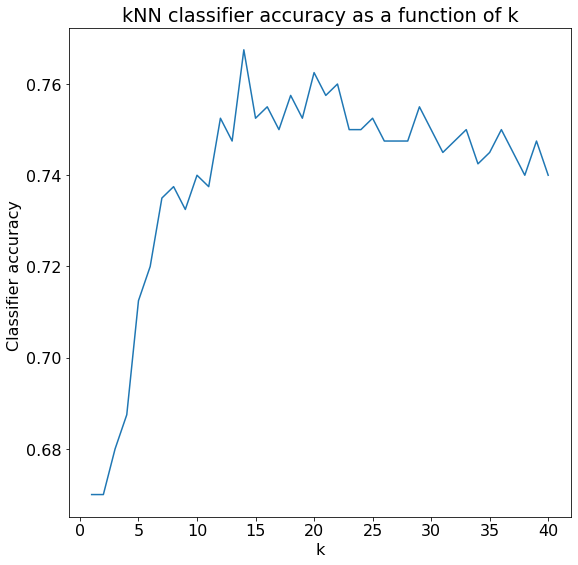

In [19]:
plt.figure(figsize = (9,9))
plt.title('kNN classifier accuracy as a function of k')
plt.plot(np.arange(1,n+1,1), kNN_acc)
plt.ylabel('Classifier accuracy ')
plt.xlabel('k')
plt.show()

The performance of the k-nearest neighbors classifier as a function of neigbors k, is plotted in the figure above. We see that the classifier has an optimal performance for a given k and deacrease in performance for higher k-values.
We detemine the optimal k and the corresponding accuracy.

In [20]:
kNN_indx = np.where(kNN_acc==np.max(kNN_acc))[0]
opt_kNN = np.max(kNN_acc)

print(f'Optimal classification accuracy is found for k = \
%d' % int(kNN_indx[0]+1))
print(f'The accuracy of the classifier is {opt_kNN} \
using this parameter value')

Optimal classification accuracy is found for k = 14
The accuracy of the classifier is 0.7675 using this parameter value


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    

### Simple perceptron
Finally, run the simple perceptron (week06) on the same set, and report and store accuracy.   
</div>

We evalute the simple perceptron classifier as a function of number of training epochs.

In [21]:
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=0.1, epochs = 1, diff=1e-3):
        """Train the self.weights on the training data with learning
        rate eta, running epochs many epochs"""
        X_train = [[1]+list(x) for x in X_train] # Put bias in position 0      
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        # Initialize all weights to 0. There are better ways!
        update = [1 for _ in range(dim)]
        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    update[i] = eta * (y - t) * x[i]
                    weights[i] -= update[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

In [22]:
N = 100
per_epochs = np.arange(1,N+1,1)

per_acc = np.zeros(len(per_epochs))
per_cl = PyPerClassifier()
for i, e in enumerate(per_epochs):
    per_cl.fit(X_train, t2_train,eta = 0.1, epochs = int(e))
    per_acc[i] = per_cl.accuracy(X_val, t2_val)

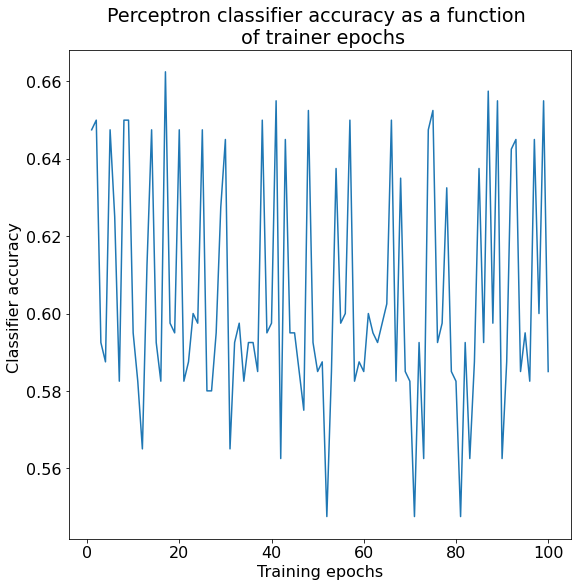

In [23]:
plt.figure(figsize = (9,9))
plt.title('Perceptron classifier accuracy as a function \n of trainer \
epochs')
plt.plot(per_epochs, per_acc)
plt.ylabel('Classifier accuracy ')
plt.xlabel('Training epochs')
plt.show()

The simple perceptron classifier does not vary its performance for different learning rates and we therefor only plot for one parameter value. We see that the accurcy as a function of traning epochs is not as "pretty" as for the previous classifiers. It seems almost that is does not matter how many epochs it is trained for. It is of course possible that there is something wrong with the implementation of the classifier, but because it was copied from the suggested solution to the weekly exercices I would expect it to perform well. 

The optimal accuracy with corresponing training epoch number is determined.

In [24]:
per_indx = np.where(per_acc==np.max(per_acc))[0]
opt_per = np.max(per_acc)
print(f'Optimal classification accuracy is found when training for \
%d epochs' % per_epochs[per_indx[0]])
print(f'The accuracy of the classifier is {opt_per} \
using this parameter value')

Optimal classification accuracy is found when training for 17 epochs
The accuracy of the classifier is 0.6625 using this parameter value


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?
    
</div>

We report the optimal accuracies achieved by the different classififers together with the parameter compination used to produce them in a table.

# Table of accuracies
| Classifier | Parameters | Accuracy |
| --- | --- | --- | 
| Linear | $\eta = 0.10$, resolution$\leq 1.4$E$-05$ | 0.6075 | 
|   |  $\eta = 0.01$, resolution$\leq 1.4$E$-06$ | 0.6075 | 
|Logistic | $\eta = 0.10$, $1.01$E$-03\leq$res$\leq 1.19$E$-03$ | 0.6475 | 
|   |  $\eta = 0.01$, $9.93$E$-05\leq$res$\leq 1.16$E$-04$ | 0.6475 | 
| kNN | k = 14 | 0.7675 |
| Perceptron | epochs = 17 | 0.6625 |

We see in the table above that the k-nearest neighbors classifier performes the best. The perceptron with its highly varying performance comes in on second with the logicstic classifier on a close third. The linear classifier performes worst, but not significantly worse than the logistic and the perceptron. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

## Multi-class classifiers
    
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

    
### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.
    
</div>

The k-nearest neighbor classifier can handle data with 3 features. We evalute the classifier in the same way as before.

In [25]:
n = 40
k_arr = np.arange(1,n+1,1)
kNN_mult_acc = np.zeros(n)
for i,k in enumerate(k_arr):
    kNN_mult_cl = PykNNClassifier(k = k)
    kNN_mult_cl.fit(X_train.tolist(), t_train.tolist())
    kNN_mult_acc[i] = kNN_mult_cl.accuracy(X_val.tolist(), t_val.tolist())

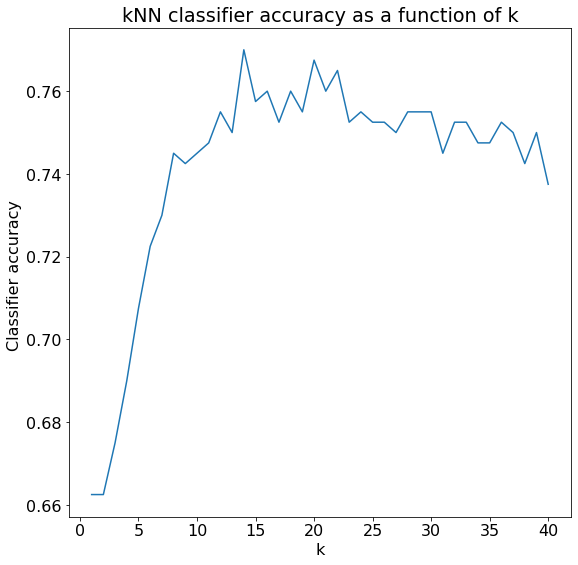

In [26]:
plt.figure(figsize = (9,9))
plt.title('kNN classifier accuracy as a function of k')
plt.plot(np.arange(1,n+1,1), kNN_mult_acc)
plt.ylabel('Classifier accuracy ')
plt.xlabel('k')
plt.show()

The figure above shows that the perfomance of the k-nearest neighbor classifier on data with three features is undistinguishable from its performance on 2 features. 

In [27]:
kNN_mult_indx = np.where(kNN_mult_acc==np.max(kNN_mult_acc))[0]
opt_mult_kNN = np.max(kNN_mult_acc)

print(f'Optimal classification accuracy is found for k = \
%d' % int(kNN_mult_indx[0]+1))
print(f'The accuracy of the classifier is {opt_mult_kNN} \
using this parameter value')


Optimal classification accuracy is found for k = 14
The accuracy of the classifier is 0.77 using this parameter value


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.
</div>

The logistic regression classifier is modified to handle datasets with three features. This is done using the one-vs-rest method. The classifier is then evaluted and its performance presented.

In [28]:
class NumpyOVRLogRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1,epochs = 5, diff = 1e-1):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        
            
        self.weights = weights = np.zeros(m+1)
        update= np.ones(m+1)*10
        classes= [0,1,2]
        # loop over classes is added inside the epoch loop
        for e in range(epochs):
            for i in classes:
                t_i = (t_train == i).astype('int') # defining the one-vs-rest class
                update = eta / k *  X_train.T @ (self.forward(X_train) - t_i)  
                weights -= update   
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')

In [29]:
ovr= NumpyOVRLogRegClass()

ovr_epochs = np.arange(1,251,1)
ovr_acc1 = np.zeros(len(ovr_epochs))
ovr_acc2 = np.zeros(len(ovr_epochs))
for i, e  in enumerate(ovr_epochs):
    ovr.fit(X_train, t_train, eta = 0.1, epochs = e)
    ovr_acc1[i] = ovr.accuracy(X_val, t_val)
    ovr.fit(X_train, t_train, eta = 0.01, epochs = e)
    ovr_acc2[i] = ovr.accuracy(X_val, t_val)



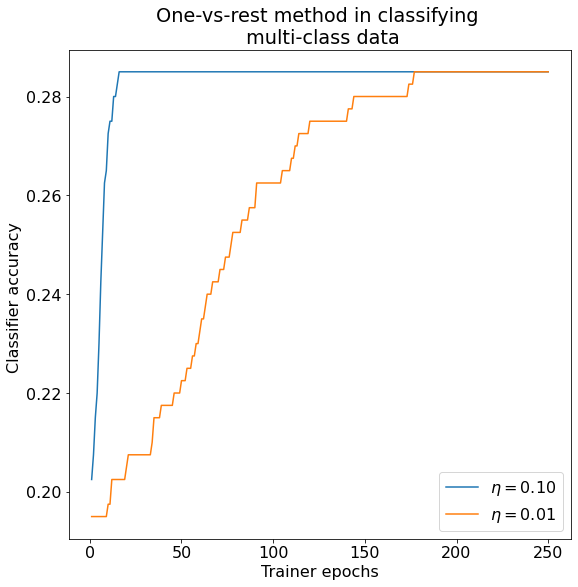

In [30]:
plt.figure(figsize = (9,9))
plt.title('One-vs-rest method in classifying \n multi-class data')

plt.plot(ovr_epochs, ovr_acc1, label=r'$\eta = 0.10$')
plt.plot(ovr_epochs, ovr_acc2, label=r'$\eta = 0.01$')

plt.ylabel('Classifier accuracy ')
plt.xlabel('Trainer epochs')
plt.legend()
plt.show()

We see that the learning rate does not affect the optimum reached, but rather how fast the classifier reaches it. We see that the classifier is significantly less accurate on datasets with three features. This is to be expected, especially since one of the classes in the training data overlap fully with the two other classes(see the first figure). 

We determine the optimal accuracy and the corresponding input parameters.

In [31]:
#for eta = 0.1
ovr_indx1 = np.where(ovr_acc1==np.max(ovr_acc1))[0]
opt_ovr1 = np.max(ovr_acc1)

print(f'Optimal resolution for eta = 0.10 is for number of epochs > \
%d' % (ovr_epochs[ovr_indx1[0]]))
print(f'The accuracy of the classifier is {opt_ovr1} \
using these parameter values')

print('\n')

#for eta = 0.01
ovr_indx2 = np.where(ovr_acc2==np.max(ovr_acc2))[0]
opt_ovr2 = np.max(ovr_acc2)

print(f'Optimal resolution for eta = 0.01 is for number of epochs > \
%d' % (ovr_epochs[ovr_indx2[0]]))
print(f'The accuracy of the classifier is {opt_ovr2} \
using these parameter values')


Optimal resolution for eta = 0.10 is for number of epochs > 16
The accuracy of the classifier is 0.285 using these parameter values


Optimal resolution for eta = 0.01 is for number of epochs > 177
The accuracy of the classifier is 0.285 using these parameter values


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    

## Adding non-linear features
    
We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g., for the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)
    
</div>

We add the three additional features described above to the traning and validation datasets.

In [32]:
#Creating new X_train and X_val with 5 features
Xt_new = np.zeros((X_train.shape[0],X_train.shape[1]+3))
Xv_new = np.zeros((X_val.shape[0],X_val.shape[1]+3))

Xt_new[:,0] = X_train[:,0];
Xt_new[:,1] = X_train[:,1] # first two features are the same
Xt_new[:,2] = X_train[:,0]**2 # x_3 = x1**2
Xt_new[:,3] = X_train[:,1]**2 # x_4 = x2**2
Xt_new[:,4] = X_train[:,0]*X_train[:,1] # x_4 = x_1*x_2

# we do the same for X_val
Xv_new = np.zeros((X_val.shape[0],X_val.shape[1]+3))

Xv_new[:,0] = X_val[:,0] 
Xv_new[:,1] = X_val[:,1] # first two features are the same
Xv_new[:,2] = X_val[:,0]**2 # x_3 = x1**2
Xv_new[:,3] = X_val[:,1]**2 # x_4 = x2**2
Xv_new[:,4] = X_val[:,0]*X_val[:,1] # x_4 = x_1*x_2

We evaluate the four classifiers with the new datasets using the same parameters as produces the optimal accuracies in each classifier. 

In [33]:
lin_cl.fit(Xt_new, t2_train, eta = 0.01, diff = 1.5e-6)
lin_acc = lin_cl.accuracy(Xv_new, t2_val)
print('Running for parameters eta = 0.01 and res = 1.5E-6')
print(f'Linear classifier accuracy is = {lin_acc}')

Running for parameters eta = 0.01 and res = 1.5E-6
Linear classifier accuracy is = 0.705


In [34]:
log_cl.fit(Xt_new, t2_train,eta = 0.1, diff = 1.02e-3)
log_acc = log_cl.accuracy(Xv_new, t2_val)
print('Running for parameters eta = 0.1 and res = 1.02E-3')
print(f'Logistic classifier accuracy is = {log_acc}')

Running for parameters eta = 0.1 and res = 1.02E-3
Logistic classifier accuracy is = 0.6925


In [35]:
kNN_cl = PykNNClassifier(k = 14)
kNN_cl.fit(Xt_new.tolist(), t2_train.tolist())
kNN_acc = kNN_cl.accuracy(Xv_new.tolist(), t2_val.tolist())
print('Running for parameter k = 14')
print(f'kNN classifier accuracy is = {kNN_acc}')

Running for parameter k = 14
kNN classifier accuracy is = 0.76


In [36]:
per_cl = PyPerClassifier()
per_cl.fit(Xt_new, t2_train,eta = 0.1, epochs = 17)
per_acc = per_cl.accuracy(Xv_new, t2_val)
print('Running for 14 training epochs')
print(f'Perceptron classifier accuracy is = {per_acc}')

Running for 14 training epochs
Perceptron classifier accuracy is = 0.64


# Table of accuracies
| Classifier |  Accuracy | |
| --- | --- | --- | 
| | 2 features | 5 features |
| Linear | 0.6075 | 0.705 |
|Logistic | 0.6475 | 0.6925 |
| kNN |0.7675 | 0.76 |
| Perceptron | 0.6625 | 0.64 |

The accuracies achieved for the different classifiers are presented in the table above. We find that the linear and logistic classifiers perform marginally better, while the k-nearest neighbor performs equivalently and the perceptron a little worse. It is possible that the classifiers could have performed better if we explored various input parameters instead of using the optimal parameters found when the classifiers where applied on the datasets with two features. With this in mind it is easy to suspect that the perceptron classifier with its large variance in performance could have performed better. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do so in two steps. In the first step, we will work concretely with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.
</div>

In [37]:
s = 1
Xs_train = (X_train-np.mean(X_train,0))/s
Xs_val = (X_val-np.mean(X_val,0))/s
Xs_test = (X_test-np.mean(X_test,0))/s

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


## Step1: One round of training

### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.
</div>

In [38]:
eta = 0.01 #Learning rate
dim_hidden = 6

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *t_train*. Beware that *t_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.
</div>

In [39]:
dim_in =  Xs_train.shape[1]  # include bias?
dim_out = np.max(t_train) + 1 # number of classes

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.
</div>

In [40]:
weights1 = np.random.uniform(-1,1,(dim_in+1, dim_hidden)) # +1 to include bias
weights2 = np.random.uniform(-1,1,(dim_in+1, dim_hidden+1)) # +1 to add bias 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.
</div>

We implement the steps in the forward phase. This consists of computing the activation of each neuron $j$ in the hidden layer. We advance to the first hidden layer by computing

$$h_j = \sum\limits_{i=1}^m x_i v_{i,j} $$

Where $x_i$ is the i-th data row contaning bias and two features. $v_{i,j}$ is the weights. We then compute the activation $a_j = g(h_j)$ using the activation function

$$ a = g(h) = \frac{1}{1+e^{-h}}$$ 

Bias is added to the first hidden layer and we advance to the second layer by computing

$$z_j = \sum\limits_{i=0}^k a_i w_{i,j} $$

Where $a$ is the activation of the first hidden layer $w$ is the weights.

In [41]:
Xt_wbias = add_bias(Xs_train) # adding bias to scaled data
xi = Xt_wbias[0,:] # one data row containing bias + 2 features


def g_func(z, beta = 3):
    return 1/(1+np.exp(-np.array((beta*z))))
    
x = xi
h1 = np.sum(weights1*x[:,np.newaxis],0)
print('shape of first hidden layer', h1.shape)
hid_act = np.array(([-1] + g_func(h1).tolist())) # hidden activations and added bias at [0]
print('Values of activation of first hidden layer:\n', hid_act)
h2 = np.sum(hid_act[np.newaxis]*weights2,1)
print('Shape of second hidden layer', h2.shape)
out_act = g_func(h2)
print('Values of activation of second hidden layer: \n', out_act)
out = np.sum([-1]+list(out_act))
print('Output', out)




print('As we can see, we have the correct dimensions: \n \
6 hidden, 7 for the second layer including a bias term and 3 dimensions in the output activations')
print('I ')


shape of first hidden layer (6,)
Values of activation of first hidden layer:
 [-1.          0.36982729  0.54669374  0.21049748  0.7316214   0.33438719
  0.69119289]
Shape of second hidden layer (3,)
Values of activation of second hidden layer: 
 [0.50116534 0.79080539 0.79542376]
Output 1.0873944911870508
As we can see, we have the correct dimensions: 
 6 hidden, 7 for the second layer including a bias term and 3 dimensions in the output activations
I 


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).
    
Calculate the delta terms in the hidden layer.
    
Update the weights.
Check that they have changed.
As the weights depend on the random initialization, there is no unique correct solution at this point. But you should be able to see that the weights have been updated.
</div>

In [42]:

t = ti = t_train[0]
y = out_act
d0 = (y-t)*y*(1-y) # will be zero if y=1 or y=t or y=0
dh = hid_act*(1-hid_act)*np.sum(weights2*d0[:,np.newaxis],0)

weights2 -= eta*d0[:,np.newaxis]*hid_act[np.newaxis]
print('printing the terms updating the weights')
print(eta*d0[:,np.newaxis]*hid_act[np.newaxis])
print('\n')
weights1 -= (eta*dh[np.newaxis]*x[:,np.newaxis])[:,1:] # skipping the bias
print((eta*dh[np.newaxis]*x[:,np.newaxis])[:,1:])


printing the terms updating the weights
[[ 1.24707987e-03 -4.61204169e-04 -6.81770762e-04 -2.62507170e-04
  -9.12390321e-04 -4.17007536e-04 -8.61972733e-04]
 [ 3.46075294e-04 -1.27988089e-04 -1.89197198e-04 -7.28479775e-05
  -2.53196092e-04 -1.15723146e-04 -2.39204782e-04]
 [ 3.32896294e-04 -1.23114135e-04 -1.81992321e-04 -7.00738311e-05
  -2.43554054e-04 -1.11316257e-04 -2.30095550e-04]]


[[-3.08023150e-04 -7.77735582e-05 -3.15020614e-05 -2.02174140e-04
   2.47321739e-04  7.65907798e-05]
 [-2.50681106e-04 -6.32951179e-05 -2.56375911e-05 -1.64537104e-04
   2.01279959e-04  6.23325273e-05]
 [ 2.32850503e-04  5.87930230e-05  2.38140245e-05  1.52833806e-04
  -1.86963192e-04 -5.78989002e-05]]


We see the terms updating the weights are small, but non-zero.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.
</div>

In [43]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.001, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden
        # Should you put additional code here?
        
    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs."""
        X_train = add_bias(X_train)
        
        dim_in =  X_train.shape[1]  # include bias?
        dim_out = np.max(t_train) + 1 # number of classes
        
        self.weights1 = np.random.uniform(-1,1,(dim_in, dim_hidden)) # +1 to include bias
        self.weights2 = np.random.uniform(-1,1,(dim_in, dim_hidden+1)) # +1 to add bias 
        
        for e in range(epochs):
            for x, t in zip(X_train, t_train): # dont have time to vectorize this
                self.forward(x)
                self.backward(t)
        
            
    def forward(self, x):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        h1 = np.sum(self.weights1*x[:,np.newaxis],0)
        self.hid_act = np.array(([-1]+ g_func(h1).tolist())) # hidden activations
        
        h2 = np.sum(self.hid_act[np.newaxis]*self.weights2,1)
        self.out_act = g_func(h2)
        
        return out_act
    
    def backward(self, t):
        y = self.out_act
        d0 = (y-t)*y*(1-y)
        dh = self.hid_act*(1-self.hid_act)*np.sum(self.weights2*d0[:,np.newaxis],0)
        
        self.weights2 -= self.eta*d0[:,np.newaxis]*self.hid_act[np.newaxis]
        self.weights1 -= (self.eta*dh[np.newaxis]*x[:,np.newaxis])[:,1:] # skipping the bias
        return d0
    
    
    def predict(self, x_in, threshold=0.5):
        """Predict the value for the item x"""
        x = np.array(([-1] + list(x_in)))
        score = np.sum(self.forward(x))
        return int(score>threshold)
    
    def accuracy(self, X_test, t_test):
        pred = [self.predict(x) for x in X_test.tolist()]
        equal = len([(p, g) for (p,g) in zip(pred, t_test.tolist()) if p==g])
        return equal/len(t_test)
        
        

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

</div>

In [50]:
test = MNNClassifier(eta = 0.001, dim_hidden = 6)
test.fit(Xs_train, t_train, epochs= 50)
acc = test.accuracy(Xs_val, t_val)
print('Accuracy is = ', acc)

Accuracy is =  0.4725


The dimensions check out and produce a result, but I don't think this is correct. As far as I can tell, the classifier puts all the instances in the same class. The score is the same for all instances which I think indicates that there is a problem with the training module. I'm also unsure about the way the score is determined. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

## Make a neural network classifier for (X,t)
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train it on (X_train, t_train) and test it on (X_val, t_val).
Tune the hyper-parameters for the best result.
</div>

In [51]:
dims = np.arange(4,10,2)
epochs = np.arange(5,50,20)
acc = np.zeros((len(dims), len(epochs)))
for i, dim in enumerate(dims):
    for j, e in enumerate(epochs):
        a=1
        mnn_cl = MNNClassifier(eta = 0.001, dim_hidden = dim)
        mnn_cl.fit(Xs_train, t_train, epochs= e)
        acc[i,j] = mnn_cl.accuracy(Xs_val, t_val)

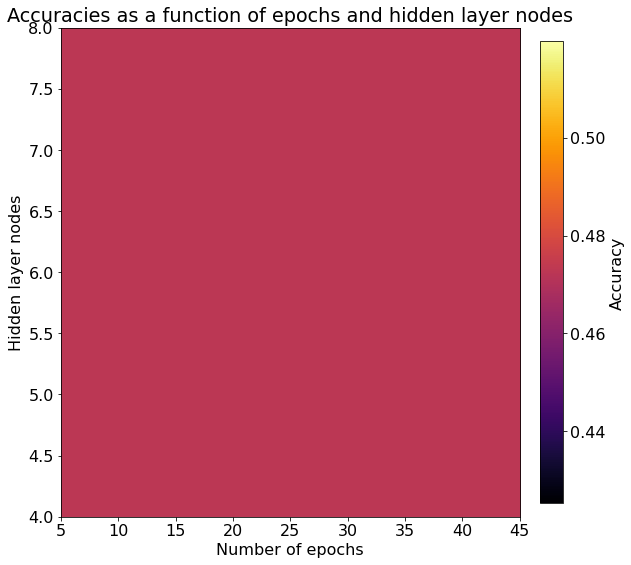

In [52]:

plt.figure(figsize = (9,9))
plt.title('Accuracies as a function of epochs and hidden layer nodes')
im = plt.imshow(acc, cmap='inferno', extent=[epochs[0], epochs[-1], dims[0], dims[-1]])
plt.axis('auto')
plt.xlabel('Number of epochs')
plt.ylabel('Hidden layer nodes')
#plt.contour(acc)
plt.colorbar(im,fraction=0.046, pad=0.04, label='Accuracy')
plt.show()

We see that varying the input parameters for number of traning epochs and hidden nodes does not change the accuracy of the classifier. We would expect some variation, so this is another indicator that the multi-layer neural network classifier does not work as intended. If the classifier did work, a simple hill climber method would be a good way of finding an optimal parameter combination. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

## For master's students: Early stopping
There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and plot them as in figure 4.11 in Marsland. 

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 
    
</div>

In [48]:
epochs = np.arange(5,50,1)
err_train = np.zeros((len(epochs)))
err_val = np.zeros((len(epochs)))

for i, e in enumerate(epochs):
    mnn_cl = MNNClassifier(eta = 0.001, dim_hidden = 6)
    mnn_cl.fit(Xs_train, t_train, epochs= 10)
    err_train[i] = np.sum(sum([np.abs(mnn_cl.backward(t)) for t in t_train]))
    a = [mnn_cl.forward(np.array(([-1]+list(x)))) for x in Xs_val]
    err_val[i] = np.sum(sum([np.abs(mnn_cl.backward(t)) for t in t_val]))
    

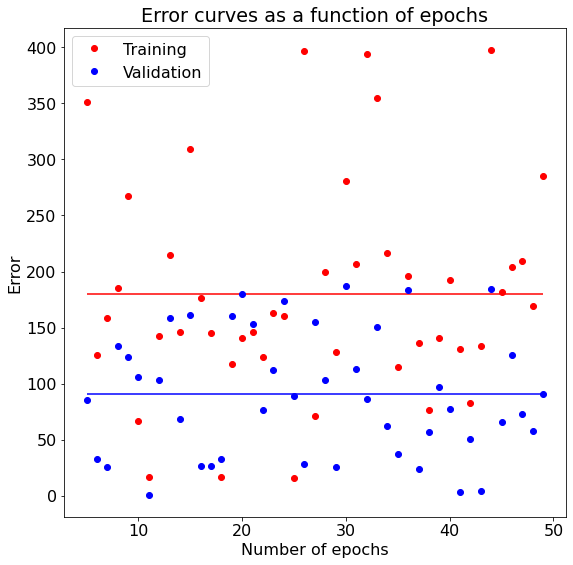

In [49]:
plt.figure(figsize=(9,9))
plt.title('Error curves as a function of epochs')
plt.plot(epochs, err_train,'ro', label='Training')
plt.plot(epochs, err_val, 'bo', label='Validation')
plt.hlines(np.mean(err_train), epochs[0], epochs[-1], color='red')
plt.hlines(np.mean(err_val), epochs[0], epochs[-1], color='blue')
plt.xlabel('Number of epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

If the error were controlled by the number of epochs we run for we would expect the traning error to decrease indefinitely and the validation error to decrease to some optimum before increasing againg due to overfitting. If as we suspect, the classifier does not work at all, the error are more likely to be driven by the random initation of the weights. If so the errors would be expected to be normally distributed around some mean unique to the input set. This latter case is exaxtly what we see. We could of cource have performed some statistical analysis to confirm this but the more relevant information is that this plot is also consistent with our hypothesis that the classifier does not work. 

If the classifier had worked, we would be interested in adding an option to have the classifier end the epoch loop when validating the data at the point where the error had reached this optimum. This would be quite straight forward to do and could be solved in numerous ways. One way would be to compute the error gradient for each epoch and end the loop when the gradient becomes positive. In order to compute this gradient we would need to save the acumulative error for two epochs at a time, the previous and the new if you will. This is trivial to do. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

</div>

Because the classifier has to work at least to some extent for me to answer therese questions I won't be able to. I hope you see that I've put in a lot of effort on the rest of the assignment and that this will be enough to get a pass.